In [1]:
import skimage.data as skid
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

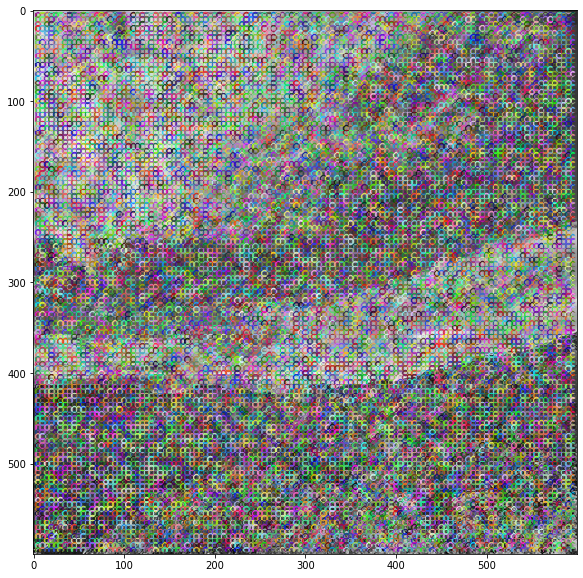

In [17]:
img = cv2.imread("test.jpg", 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                                    for x in range(0, gray.shape[1], step_size)]
img = cv2.drawKeypoints(gray, kp, img)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [30]:
orb = cv2.ORB_create(edgeThreshold=0)
dense_orb = orb.compute(gray, kp)

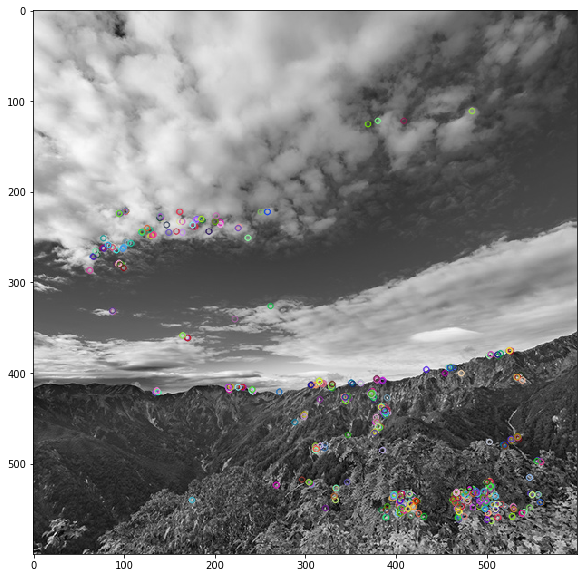

In [29]:
detected_kp = orb.detect(gray, None)
res = orb.compute(gray, detected_kp)
res[1].shape

img2 = cv2.drawKeypoints(gray, detected_kp, img)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [34]:
brisk = cv2.BRISK_create()
dense_brisk = brisk.compute(gray, kp)

# k-medoid

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [319]:
class KMedoids(object):
    def __init__(self, n_clusters, max_iter=300, tol=0, init="kmeans++", metric="euclidean"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.loop_flag = True
        self.lb = LabelBinarizer()
        self.tol = tol
        self.num_loop = 0
        self.last_centroids = set([0])
        self.init = init
        self.metric = metric
        
    def fit(self, X):
        """
        データに対してクラスタリングを実施する
        X : 2D-np.array,  (n_samples, n_dim)
        """
        # 距離行列を指定したmetricで計算
        self.D = cdist(X, X, self.metric)
        
        self.n_samples, n_dim = X.shape
        self._init_centroids()
        
        # fit完了後に最新のラベルを参照できるようにするため、ループの最後にlabel更新を入れる
        # 一回目(初期値)のlabel更新はループ前で実施
        self._make_labels()
        
        # 終了条件：centroidに変化なし  or  ループ回数がmax_iterに到達
        while (self.num_loop <= self.max_iter) and self.loop_flag:
            one_hot_labels = self._encode_labels_to_OneHot()
            self._update_centroids(one_hot_labels)
            self._make_labels()
            self.num_loop += 1
            
    def _init_centroids(self):
        """
        centroidの初期値を選択する
        self.init : "random"   ->  乱数で選択
                    "kmeans++" ->  初期centroidが近づきすぎないような確率分布に従って選択
        """
        if self.init == "kmeans++":
            centroids = []
            for n in range(self.n_clusters):
                if n == 0:
                    # 最初のセントロイドは乱数で決定する
                    centroid = np.random.choice(range(self.n_samples), 1, replace=False)
                    centroids.extend(centroid)
                else:
                    # 2つ目以降はkmeans++の方法で選択
                    
                    # centroidとして選ばれたサンプル以外から次のcentroidを選ぶ
                    remained_samples = set(range(self.n_samples)) - set(centroids)
                    remained_samples = list(remained_samples)
                    
                    # 各サンプルについて最近傍centroidとの距離を計算
                    distance = np.delete(self.D, centroids, axis=0)
                    distance = distance[:, centroids]
                    min_distance = distance.min(axis=1)
                    
                    # d(x_i)^2 / sum(d(x_i)^2) の確率分布に従い、次のcentroidを選ぶ
                    sqrd_min_distance = min_distance * min_distance
                    probs = sqrd_min_distance / sqrd_min_distance.sum()
                    centroid = np.random.choice(remained_samples, 1, p=probs)
                    centroids.extend(centroid)
            self.centroids = np.array(centroids)
        elif self.init == "random":
            self.centroids = np.random.choice(range(self.n_samples), self.n_clusters, replace=False)
            
    def _make_labels(self):
        """
        サンプルがどのクラスタに所属するかのラベルを計算する
        output: np.array,  self.labels  (shape=(n_samples, n_clusters))
        """
        self.labels = np.argmin(self.D[:, self.centroids], axis=1)
            
    def _encode_labels_to_OneHot(self):
        if self.n_clusters == 2:
            result = np.hstack((self.labels.reshape(-1, 1), 1 - self.labels.reshape(-1, 1)))
        else:
            result = self.lb.fit_transform(self.labels)
        return result
    
    def _update_centroids(self, one_hot_labels):
        """
        1. それぞれのクラスタ内において、クラスタ内の他のすべての点との距離が最小になる点をcentroidとする
        2. centroidに変化がなければ終了する(self.loop_flag = False とする)
        """
        # 各クラスタ内の二点間の距離を計算する
        # D_in_clusters.shape == (n_clusters, n_samples, n_samples), 対象行列
        D_in_clusters = (one_hot_labels[np.newaxis, :, :] * one_hot_labels[:, np.newaxis, :]).swapaxes(0, 2)
        D_in_clusters = D_in_clusters * self.D[np.newaxis, :, :]
        
        # 各サンプルをcentroidとしたときの距離の総和が最小となる点を新たなcentroidとする
        each_sample_D = np.sum(D_in_clusters, axis=1)
        np.place(each_sample_D, each_sample_D == 0, float("inf"))
        self.centroids = np.argmin(each_sample_D, axis=1)
        
        # 終了条件判定
        self._judge_exit_condition()
        
    def _judge_exit_condition(self):
        unchanged_centroids = self.last_centroids.intersection(set(self.centroids))
        if len(unchanged_centroids) == self.n_clusters:
            self.loop_flag = False
        else:
            self.last_centroids = set(self.centroids)

In [336]:
x_data, labels = make_blobs(n_samples=300,
                                n_features=3,
                                centers=n_cluster,
                                cluster_std=3.0,
                                shuffle=True,
                                random_state=10)
km = KMedoids(3)
km.fit(x_data)
km.D.shape

(300, 300)

In [337]:
km.centroids

array([66, 90, 71])

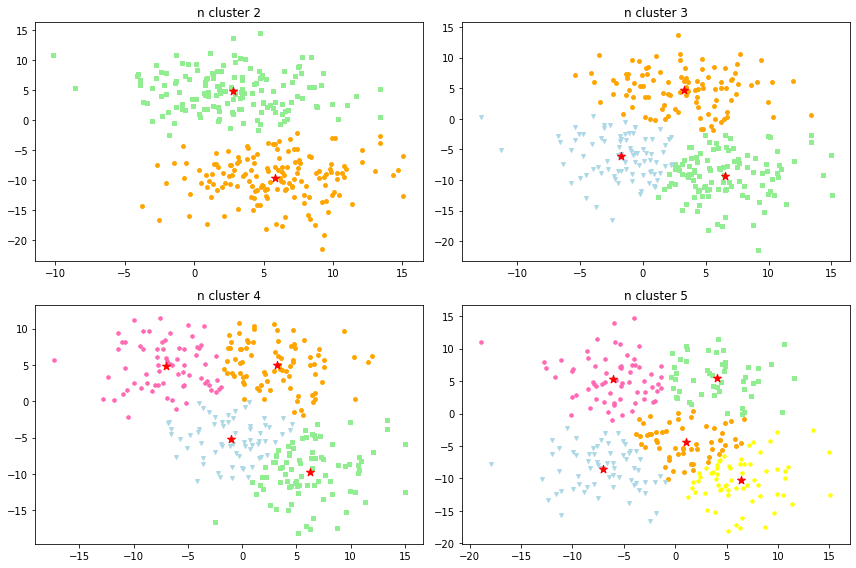

In [316]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

n_clusters = [2, 3, 4, 5]
colors = ['lightgreen', 'orange', 'lightblue', 'hotpink', 'yellow']
markers = ['s',              'o',         'v',       'h',      'p']

plt.figure(figsize=(12, 8))

for plot_num, n_cluster in enumerate(n_clusters):

    # 指定したクラスタ数のデータを作ってくれる
    # cluster_stdでデータの散らばり具合を調整できる
    x_data, labels = make_blobs(n_samples=300,
                                n_features=2,
                                centers=n_cluster,
                                cluster_std=3.0,
                                shuffle=True,
                                random_state=10)

    # k-meansは一行で行える
    # n_clustersでクラスタ数を指定し、initで初期化方法を指定している
    # initの初期化は「k-means++」であり、これは後ほど説明する
    km = KMeans(n_clusters=n_cluster, init="random")

    predicted_labels = km.fit_predict(x_data)
    centroids = km.cluster_centers_

    # クラスタリング結果の可視化
    plt.subplot(2, 2, plot_num+1)
    for i, label in enumerate(sorted(np.unique(predicted_labels))):
        # 分類した結果のクラスをプロット
        plt.scatter(x_data[predicted_labels==label, 0],
                    x_data[predicted_labels==label, 1],
                    c=colors[i],
                    marker=markers[i],
                    s=15)
    
    # 最終的なセントロイドをプロット
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                c='red',
                marker='*',
                s=70)

    plt.title('n cluster '+str(n_cluster))

plt.tight_layout()
# plt.savefig("kmeans.png")
plt.show()

In [232]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

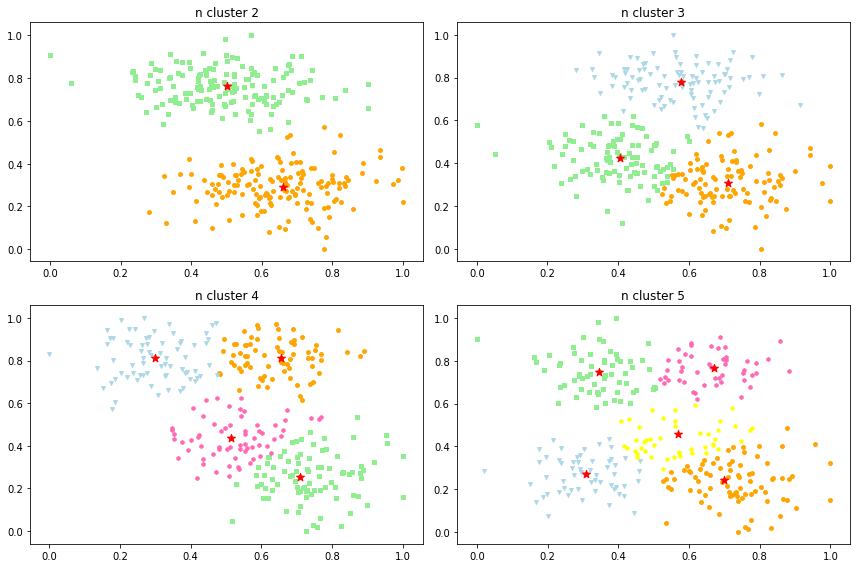

In [329]:
n_clusters = [2, 3, 4, 5]
colors = ['lightgreen', 'orange', 'lightblue', 'hotpink', 'yellow']
markers = ['s',              'o',         'v',       'h',      'p']

plt.figure(figsize=(12, 8))

for plot_num, n_cluster in enumerate(n_clusters):

    x_data, labels = make_blobs(n_samples=300,
                                n_features=2,
                                centers=n_cluster,
                                cluster_std=3.0,
                                shuffle=True,
                                random_state=10)
    ss = StandardScaler()
    ms = MinMaxScaler()
#     x_data = ss.fit_transform(x_data)
    x_data = ms.fit_transform(x_data)

    km = KMedoids(n_clusters=n_cluster, init="++")

    km.fit(x_data)
    predicted_labels = km.labels
    centroids = km.centroids
    centroids = x_data[centroids, :]

    plt.subplot(2, 2, plot_num+1)
    for i, label in enumerate(sorted(np.unique(predicted_labels))):
        plt.scatter(x_data[predicted_labels==label, 0],
                    x_data[predicted_labels==label, 1],
                    c=colors[i],
                    marker=markers[i],
                    s=15)
    
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                c='red',
                marker='*',
                s=70)

    plt.title('n cluster '+str(n_cluster))

plt.tight_layout()
plt.show()